# Constrained MDPs

This is my (Peter Schmidt-Nielsen's) attempt to follow along and implement what was described in an email written by Tong Mu.

There are three parts:
1. Finding the optimal policy for a known MDP. (via value iteration)
2. Finding the optimal policy for a known MDP. (via linear programming)
3. Finding the optimal steady-state policy for a known MDP subject to a constraint. (via linear programming)

Finally, there's an observation that (2) and (3) are duals of each other!

## 1: Unconstrained MDP, via value iteration

To start with, let's do plain old value iteration for an MDP. We'll start by generating a random MDP.

In [1]:
import random
import numpy as np

def make_mdp(state_count, action_count):
    # Make some random transition probabilities.
    transition_probs = np.exp(5 * np.random.randn(state_count, action_count, state_count))
    transition_probs /= transition_probs.sum(axis=-1)[..., np.newaxis]

    # Make some random transitions give some random reward, biasing towards penalties.
    rewards = np.random.randint(-17, 10, size=(state_count, action_count, state_count))

    return {
        "state_count": state_count,
        "action_count": action_count,
        # trans[s, a, s'] is the probability of transitioning from s to s' under action a.
        "trans": transition_probs,
        # rewards[s, a, s'] is the reward given by transitioning from s to s' from action a.
        "rewards": rewards,
    }

main_mdp = make_mdp(
    state_count=10,
    action_count=2,
)
gamma = 0.75

To do value iteration, we iterate the following to find a fixed point $V$ (solution to the Bellman equation):
$$ V'(s) = \max_a \sum_{s'} \mathrm{trans}[s, a, s'] \, \big(\mathrm{rewards}[s, a, s'] + \gamma V(s')\big) $$

In [2]:
def value_iteration(mdp, gamma, iterations=100):
    values = np.zeros(shape=mdp["state_count"])
    for _ in range(iterations):
        values = (mdp["trans"] * (mdp["rewards"] + gamma * values)).sum(axis=-1).max(axis=-1)
    return values

value_iteration(main_mdp, gamma)

array([  3.58873285,  12.12336257,  -9.41499433,  -4.56413414,
       -13.10467415,   1.55688255,   9.24490558,   4.24928972,
         1.15689845,   1.02660245])

## 2: Unconstrained MDP, via linear programming

(Per Mu, personal communication, 14th Dec 2020)

Observe that claiming $x = \max_i y_i$ is equivalent to claiming that $x$ is the minimal value such that $\forall i, x \ge y_i$.
We will use this observation to rewrite each of the maximizations in the Bellman equation from before into a collection of linear constraints.
In particular, we want:
$$ \forall s, V(s) = \max_a \sum_{s'} \mathrm{trans}[s, a, s'] \, \big(\mathrm{rewards}[s, a, s'] + \gamma V(s')\big) $$
Thus, for each $s$ we get a collection of constraints for each action $a$ implementing a single max operator:
$$\begin{align}
    \forall s \forall a, \quad V(s) &\ge \sum_{s'} \mathrm{trans}[s, a, s'] \, \big(\mathrm{rewards}[s, a, s'] + \gamma V(s')\big) \\
    \underbrace{V(s) - \gamma \sum_{s'} \mathrm{trans}[s, a, s'] \, V(s')}_{\text{Entries in the constraint's row}} &\ge \underbrace{\sum_{s'} \mathrm{trans}[s, a, s'] \, \mathrm{rewards}[s, a, s']}_{\text{Constant term on the constraint}}
\end{align}$$
This is precisely a linear program.

In [3]:
import scipy.optimize

def linprog_values(mdp, gamma):
    # Our constraint matrix must have shape [constraint_count, variable_count],
    # where constraint_count = state_count * action_count, and variable_count = state_count.

    # Our constraint matrix has two terms, corresponding to the two terms in the LHS above.
    # First, the V(s) term:
    constraint_matrix = np.repeat(np.eye(mdp["state_count"]), mdp["action_count"], axis=0)
    # Second, the -γ sum_{s'} trans[s, a, s'] V(s') term:
    constraint_matrix += -gamma * mdp["trans"].reshape((-1, mdp["state_count"]))

    # Our constraint bounds correspond to the RHS above:
    constraint_bounds = (mdp["trans"] * mdp["rewards"]).sum(axis=-1).flatten()

    result = scipy.optimize.linprog(
        # Because our goal is simply to minimize V, any positive objective whatsoever suffices.
        # (cf. Mu, personal communication.)
        c=np.ones(mdp["state_count"]),
        # Note that we'd like a $\ge$ constraint, so we negate both the constraint and bounds.
        A_ub=-constraint_matrix,
        b_ub=-constraint_bounds,
        bounds=(None, None),
    )
    if not result.success:
        raise ValueError("Linear program failed: " + result.message)
    return result.x

With any luck this LP based solution will equal the value iteration solution.

In [4]:
linprog_values(main_mdp, gamma)

/usr/local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:87: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


array([  3.58873285,  12.12336257,  -9.41499433,  -4.56413414,
       -13.10467415,   1.55688255,   9.24490558,   4.24928972,
         1.15689845,   1.02660245])

In [5]:
value_iteration(main_mdp, gamma)

array([  3.58873285,  12.12336257,  -9.41499433,  -4.56413414,
       -13.10467415,   1.55688255,   9.24490558,   4.24928972,
         1.15689845,   1.02660245])

Huzzah, the two results are equal, it worked!

## 3: Constrained MDP, via linear programming

(Also per Mu, personal communication, 14th Dec 2020)

Now imagine each $(\text{s}, \text{a})$ pair has an associated constraint-cost $\mathrm{constraint\_costs}[s, a]$ and we only want a policy that, in steady-state, consumes no more than $\delta$ units of constraint-cost in expectation per step.

To do this, we compute an occupancy measure $y(s, a)$, giving a distribution over which edges (i.e. state-action pairs) we take under the optimal policy in steady-state.
We know that the occupancy measure must be a normalized probability distribution:
$$ \sum_{s, a} y(s, a) = 1 $$
Additionally, we know that all of the probability flowing into a state in the MDP must equal all of the probability flowing out of it:
$$ \forall s', \quad \underbrace{\sum_{s, a} \mathrm{trans}[s, a, s'] \, y(s, a)}_{\text{Probability flowing into $s'$}} = \underbrace{\sum_{a} y(s', a)}_{\text{Probability flowing out of $s'$}} $$
In this framing we may now easily encode our constraint-cost limit of $\delta$:
$$ \sum_{s, a} \mathrm{constraint\_costs}[s, a] \, y(s, a) \le \delta $$
Finally, we would like to maximize the expected reward of an action we take in steady-state, namely the quantity:
$$ \sum_{s, a, s'} \mathrm{trans}[s, a, s'] \, \mathrm{rewards}[s, a, s'] \, y(s, a) $$
The above form a linear program.

In [6]:
# constraint_costs[s, a] gives the constraint-cost of taking action a from state s.
constraint_costs = np.random.uniform(0, 1, size=(main_mdp["state_count"], main_mdp["action_count"]))

def constrained_linprog_occupancy(mdp, constraint_costs, delta):
    # Our equality constraint matrix must have shape [constraint_count, variable_count],
    # where constraint_count = state_count + 1, and variable_count = state_count * action_count.
    
    # Our constraint matrix has two terms: the probability flowing in, and out.
    # First, the probability flowing into s':
    equality_constraint_matrix = mdp["trans"].reshape((-1, mdp["state_count"])).T.copy()
    # Second, the probability flowing out of s':
    equality_constraint_matrix -= np.repeat(np.eye(mdp["state_count"]), mdp["action_count"], axis=0).T

    # Add a final constraint enforcing normalization of the occupancy measure.
    equality_constraint_matrix = np.append(
        equality_constraint_matrix, [[1] * mdp["state_count"] * mdp["action_count"]], axis=0,
    )

    objective_vector = (mdp["trans"] * mdp["rewards"]).sum(axis=-1).flatten()

    result = scipy.optimize.linprog(
        # Here we negate because we'd like to maximize instead of minimize.
        c=-objective_vector,
        A_eq=equality_constraint_matrix,
        b_eq=[0.0] * mdp["state_count"] + [1.0],
        # Demand that we don't exceed our constraint-cost budget.
        A_ub=[constraint_costs.flatten()],
        b_ub=[delta],
    )
    if not result.success:
        raise ValueError("Linear program failed: " + result.message)
    occupancy_under_optimal_policy = result.x
    return {
        "score": objective_vector @ occupancy_under_optimal_policy,
        "occupancy": occupancy_under_optimal_policy.reshape((mdp["state_count"], mdp["action_count"])),
    }

In [7]:
constrained_linprog_occupancy(
    mdp=main_mdp,
    constraint_costs=constraint_costs,
    delta=0.5,
)

<ipython-input-6-06fafc557bba>:21: OptimizeWarning: A_eq does not appear to be of full row rank. To improve performance, check the problem formulation for redundant equality constraints.
  result = scipy.optimize.linprog(


{'score': 0.22227704642581816,
 'occupancy': array([[2.12490592e-01, 3.57631227e-12],
        [1.88910269e-01, 5.46803836e-13],
        [9.22043930e-04, 5.94134483e-12],
        [6.14471187e-12, 1.62865323e-01],
        [1.07324593e-12, 3.22565915e-02],
        [5.79259415e-02, 1.05241766e-01],
        [1.66459874e-12, 7.21913905e-04],
        [2.18737999e-12, 1.89920403e-01],
        [3.83926718e-12, 2.77940301e-02],
        [2.09511265e-02, 4.62493900e-12]])}

To test this out, let's see how the best score we can achieve varies as a function of our total constraint-cost budget, $\delta$.

<ipython-input-6-06fafc557bba>:21: OptimizeWarning: A_eq does not appear to be of full row rank. To improve performance, check the problem formulation for redundant equality constraints.
  result = scipy.optimize.linprog(
/usr/local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:87: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


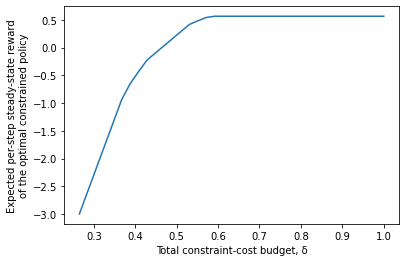

In [8]:
import matplotlib.pyplot as plt
xs = np.linspace(0, 1)
ys = []
for delta in xs:
    try:
        score = constrained_linprog_occupancy(main_mdp, constraint_costs, delta)["score"]
        ys.append(score)
    except ValueError:
        ys.append(None)
plt.plot(xs, ys)
plt.ylabel("Expected per-step steady-state reward\nof the optimal constrained policy")
_ = plt.xlabel("Total constraint-cost budget, δ")

Sure enough, the best score we can achieve goes up as we give more constraint budget.

As a final sanity check, if the constraint budget is high enough then we should simply get the unconstrained solution.
This should be extremely close to the score we get from our program of section (2) in the limit of $\gamma$ very close to 1, but rescaling the score back down.
For example, the program of section (2) with $\gamma = 0.999$ should give approximately 1,000 times the expected per-step reward of the steady-state solution as the value of every state in the MDP. (It should give approximately the same value for every state because with a $\gamma = 0.999$ it's really cheap to just walk from the worst state to the best state!)

To check this, we compare the output of the program from section (2) with the output of the program of this section.

In [9]:
# Approximately compute the expected steady-state per-step reward using our previous program.
linprog_values(main_mdp, 1 - 10**-4) / 10**4

/usr/local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:87: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


array([0.56277493, 0.563687  , 0.56095741, 0.56179701, 0.56077652,
       0.56228675, 0.56305172, 0.56285213, 0.56277044, 0.56220483])

In [10]:
# Compare to the per-step reward we get with our new program, making delta so high as to be unconstrained.
constrained_linprog_occupancy(main_mdp, constraint_costs, delta=1000)["score"]

<ipython-input-6-06fafc557bba>:21: OptimizeWarning: A_eq does not appear to be of full row rank. To improve performance, check the problem formulation for redundant equality constraints.
  result = scipy.optimize.linprog(


0.5629318775359461

Huzzah! The values nearly agree!

## Duality

Okay, wait, what!?

I was working on this, and when writing the program of section (3) I noticed that the LP I was writing seemed to be (basically) the asymmetric dual of the LP constructed in the program of section (2)!
In particular, the duality between:

1. Maximize $c^T x$ subject to $Ax \le b$. (As constructed in `linprog_values`.)
2. Minimize $b^T y$ subject to $A^T y = c, y \ge 0$. (As constructed in `constrained_linprog_occupancy`.)

In particular, note that (before the concatenation of the normalization constraint) `equality_constraint_matrix` as constructed in section 3 is _exactly_ the transpose of `constraint_matrix` from section 2!
Also, the `objective_vector` in section 3 is _exactly_ the `constraint_bounds` from section 2!

What is going on here? This seems so cool!